# Group 14 - Phase 3 - Data Cleaning
* Andrei Oprea (1768905)
* Syeni Edith Perea Zelaya (2064936)
* Yujie Zhang (1817787)

In [1]:
import pandas as pd
import pm4py

In [2]:
data_raw = pm4py.read_xes('BPI_Challenge_2017.xes.gz')

/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [3]:
# Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
# the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
# get more complete traces for our prediction

data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']

In [4]:
log = pm4py.convert_to_event_log(data_raw)

/Users/waterhorse/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [5]:
pm4py.get_end_activities(log)

{'A_Pending': 10288,
 'W_Validate application': 4036,
 'O_Cancelled': 14051,
 'O_Refused': 1977,
 'W_Call incomplete files': 631,
 'A_Cancelled': 119,
 'W_Complete application': 63,
 'A_Denied': 20,
 'W_Call after offers': 135,
 'W_Assess potential fraud': 93,
 'A_Incomplete': 29,
 'A_Validating': 3,
 'O_Sent (online only)': 12,
 'O_Sent (mail and online)': 20,
 'A_Complete': 30,
 'O_Returned': 2}

In [6]:
# Only keep two most frequent traces, we believe these are the most complete traces
filtered_log = pm4py.filter_end_activities(log, ['A_Pending','O_Cancelled'])

In [8]:
# number of distinct trace variants
len(pm4py.get_variants_as_tuples(filtered_log))

3946

In [9]:
from pm4py.objects.log.util.log import project_traces
def print_nth(log, index):
    print(str(project_traces(log)[index]))

In [10]:
print_nth(filtered_log, 0)

['A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Validating', 'O_Returned', 'A_Incomplete', 'A_Validating', 'O_Accepted', 'A_Pending']


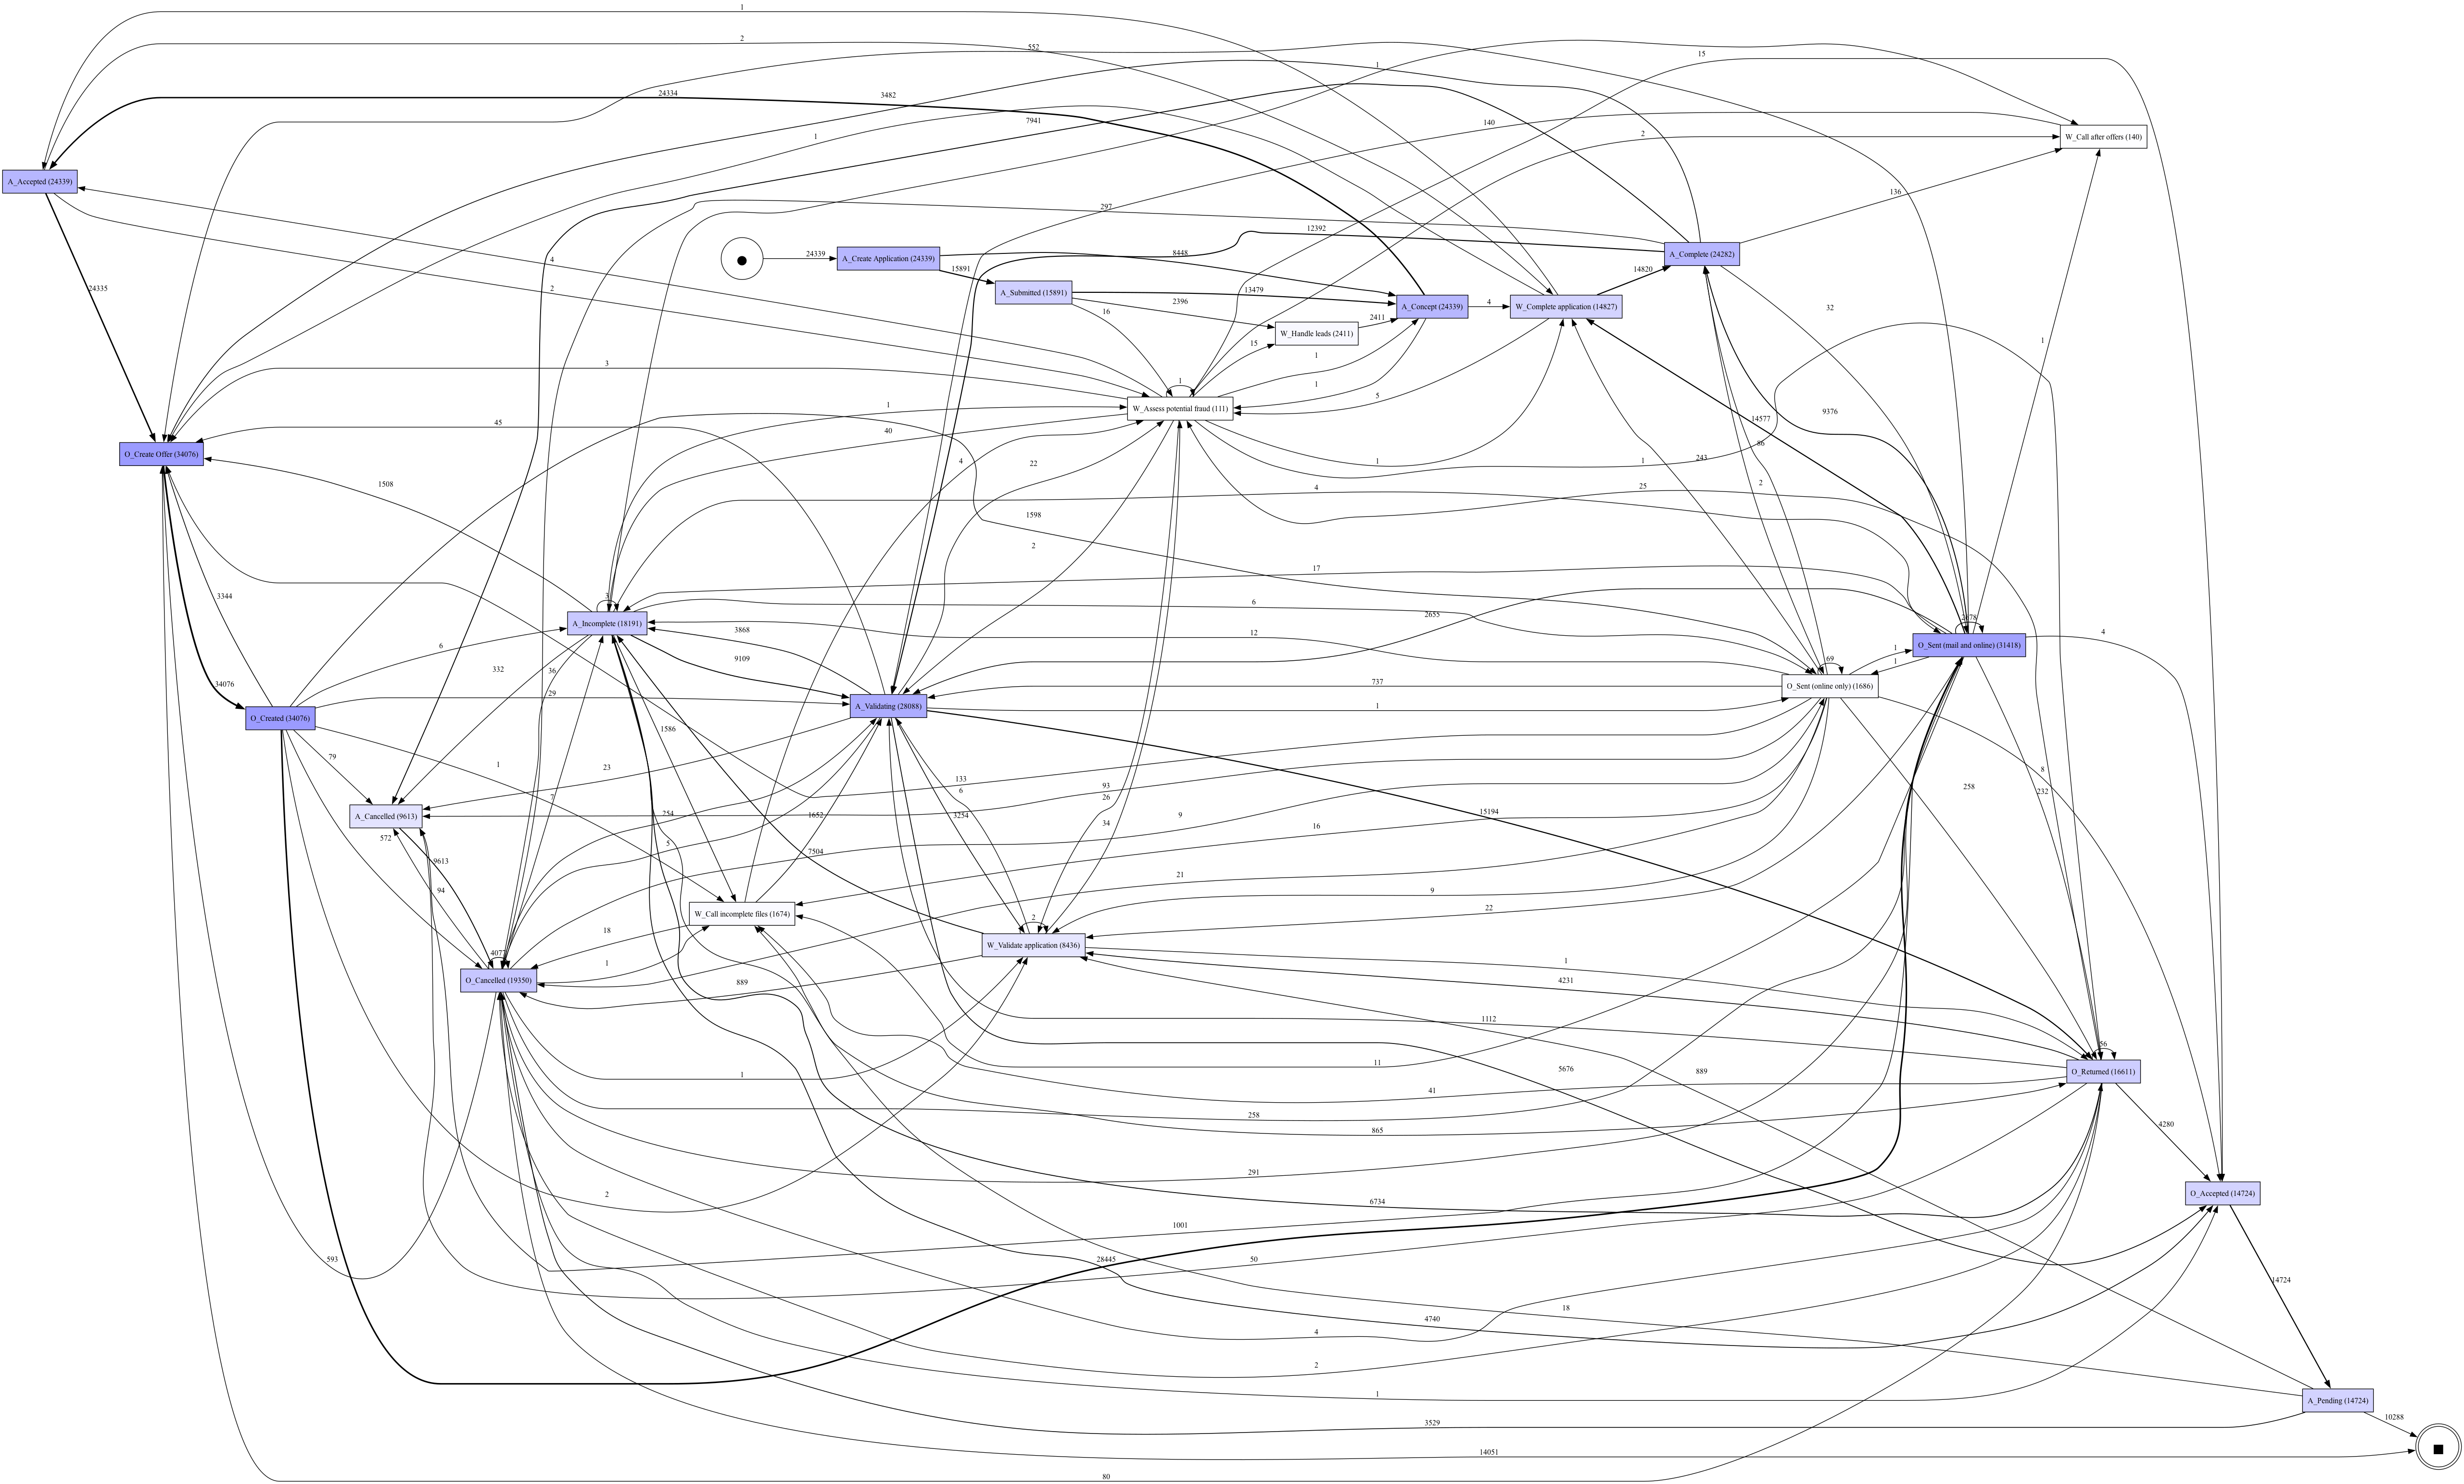

In [11]:
# Directly-Follows Graph
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

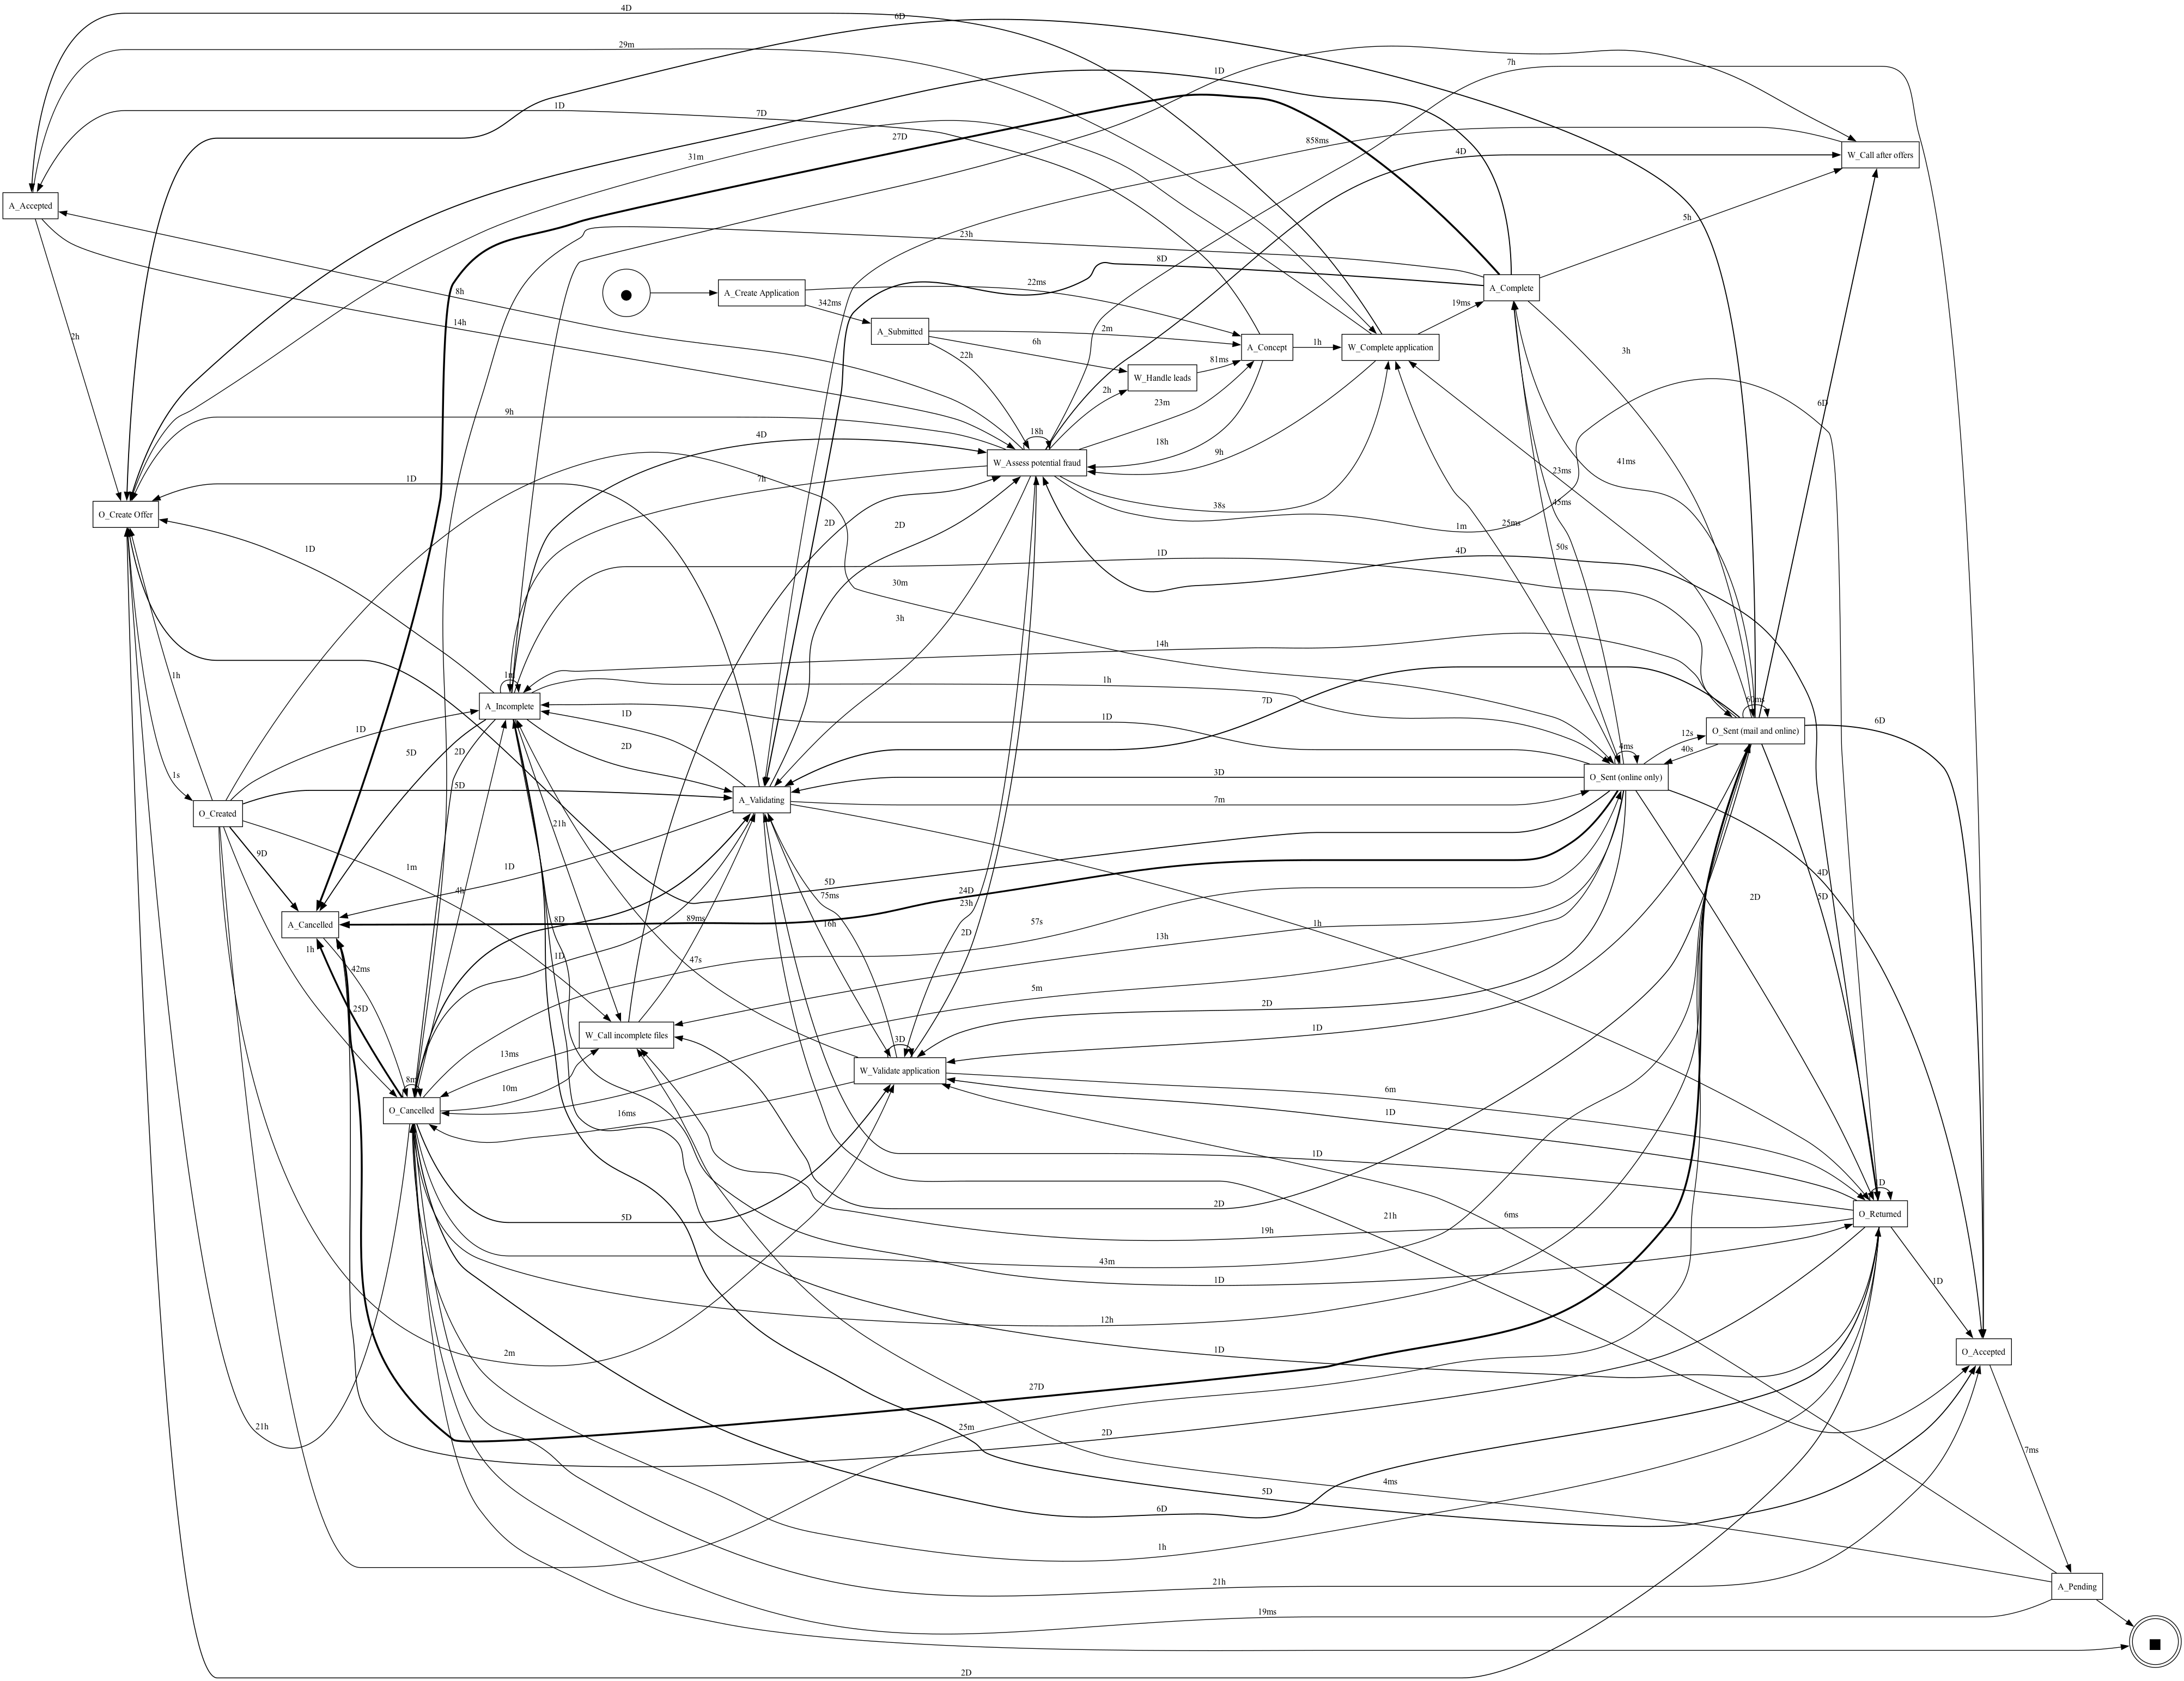

In [12]:
# Directly-Follows graph decorated with the performance(time) between the edges
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(filtered_log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

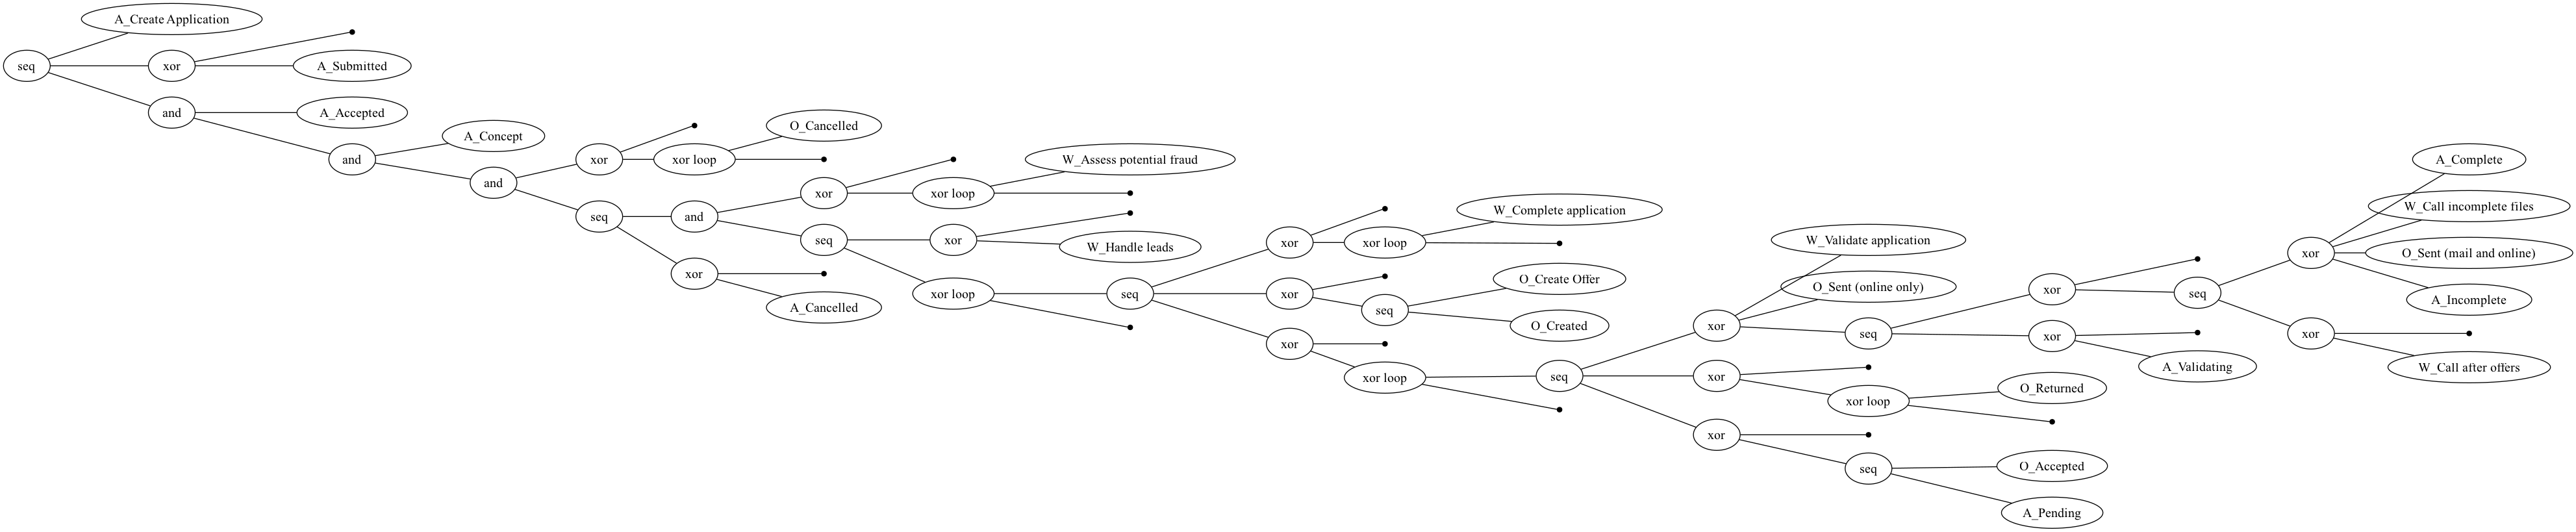

In [13]:
tree = pm4py.discover_process_tree_inductive(filtered_log)

pm4py.view_process_tree(tree)
# I have the difficulty understanding this tree graph

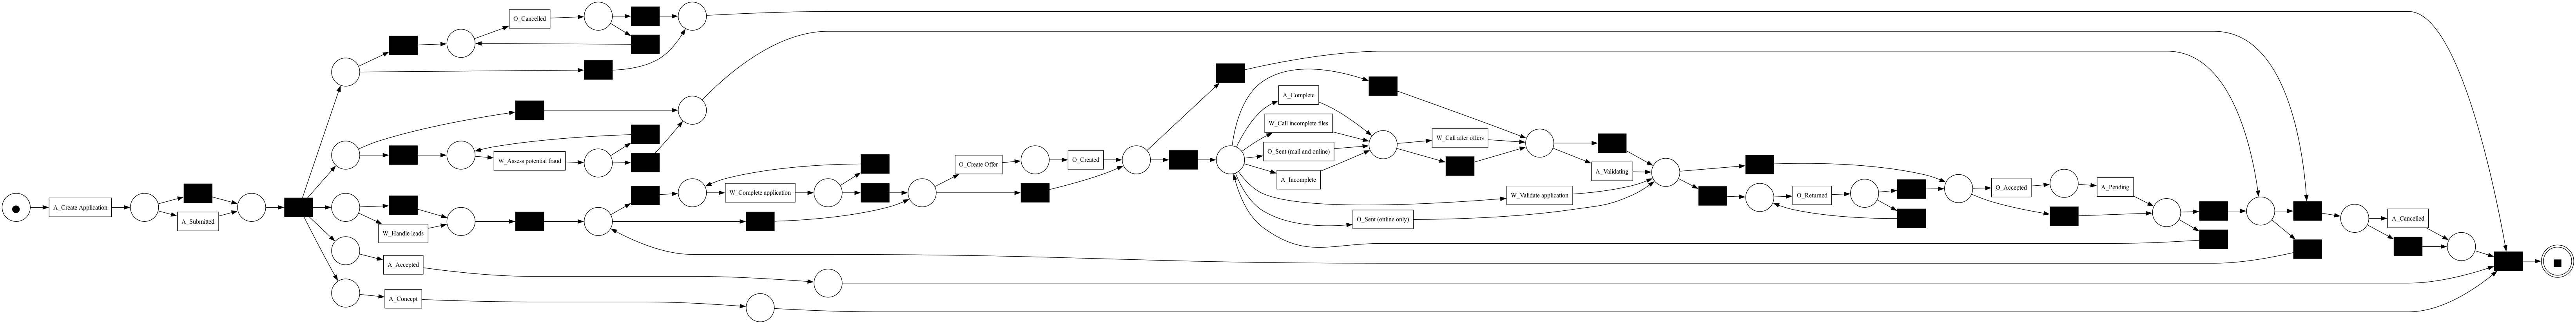

In [15]:
#Inductie Miner
inductive_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(inductive_net, initial_marking, final_marking)

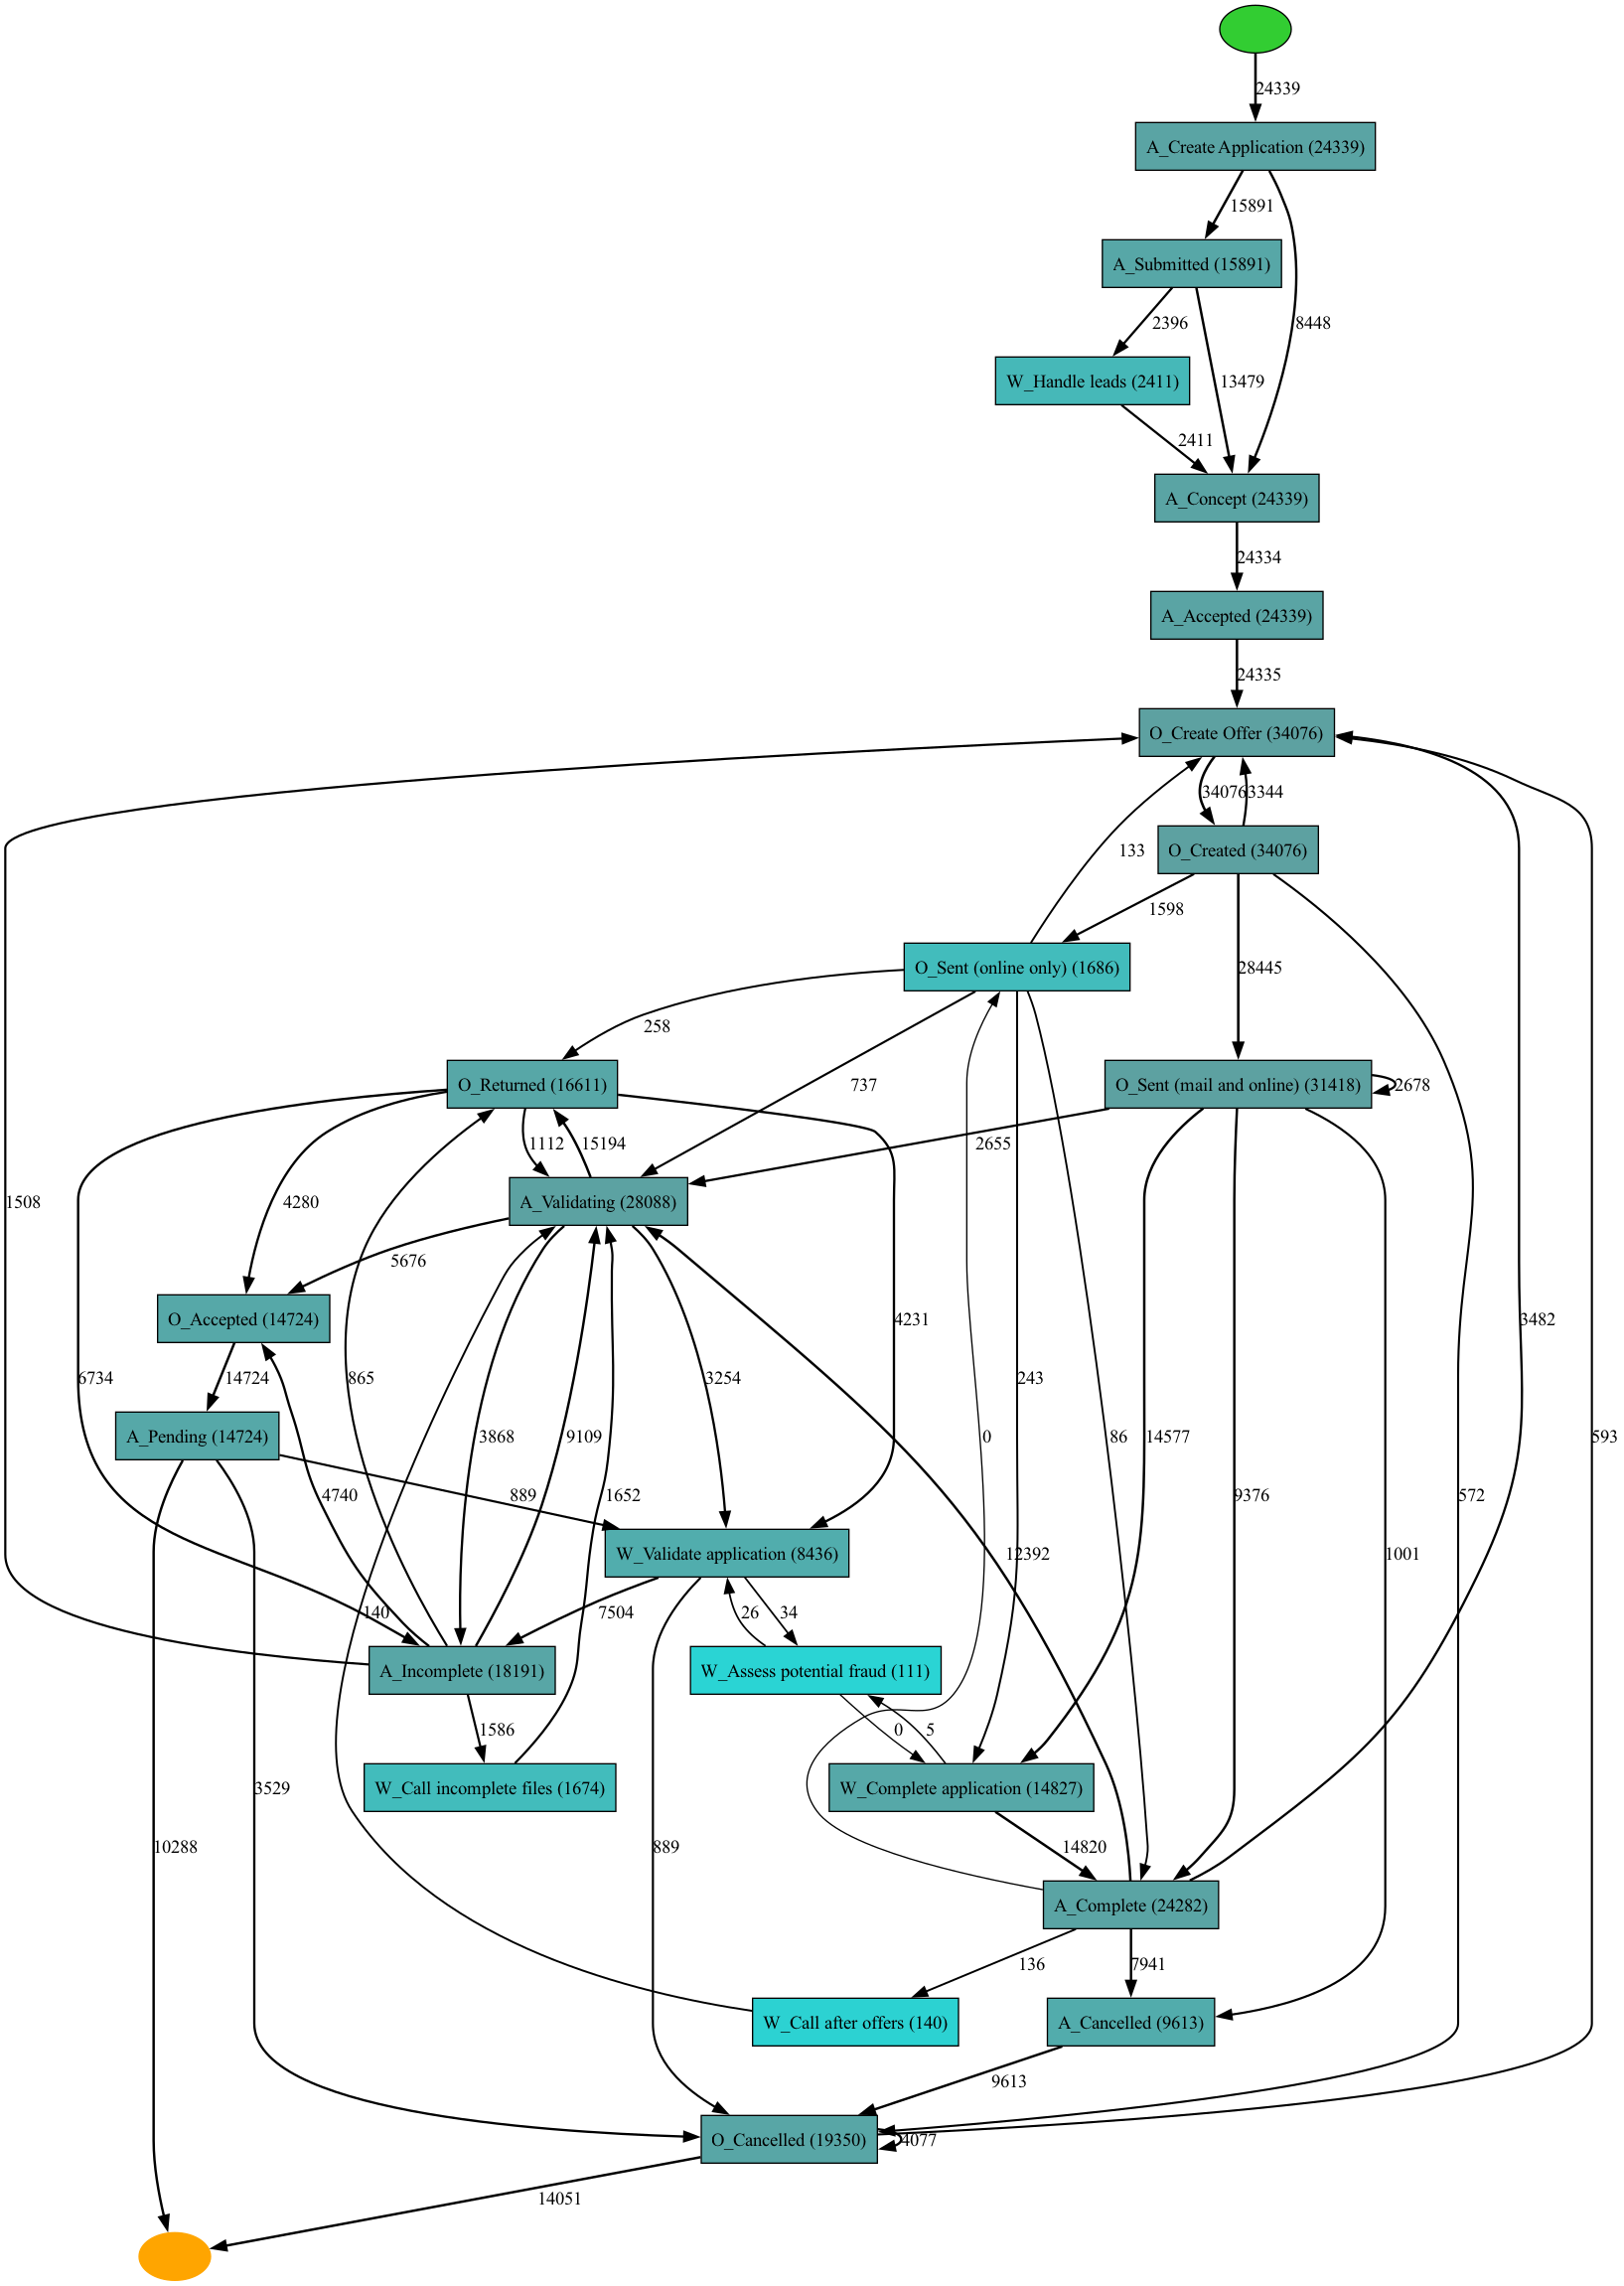

In [14]:
# Heuristic Miner
heu_net = pm4py.discover_heuristics_net(filtered_log, dependency_threshold=0.99)
pm4py.view_heuristics_net(heu_net)

In [16]:
# Use inductive_net we gained one step before to compute fitness
fitness_alignments = pm4py.fitness_alignments(data_raw, inductive_net, initial_marking, final_marking, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_alignments

aligning log, completed variants ::   0%|          | 0/5623 [00:00<?, ?it/s]

{'percFitTraces': 85.87387730489701,
 'averageFitness': 0.984203910117332,
 'percentage_of_fitting_traces': 85.87387730489701,
 'average_trace_fitness': 0.984203910117332,
 'log_fitness': 0.9837757691308656}